# Preprocessing and Feature Engineering

We tokenize, stem, and TF-IDF vectorize the tweets in preparation for training our classification model.

## Table of Contents

1. [Collecting Tweets](01-Gathering-Data.ipynb)
1. [Feature Engineering with TF-IDF](02-Feature-Engineering.ipynb)
1. [Benchmark Model](03-Benchmark-Model.ipynb)
1. [Feature Engineering & Model Tuning with Doc2Vec](04-Model-Tuning.ipynb)
1. [Making Predictions on Test Data](05-Making-Predictions.ipynb)
1. [Visualizing a Disaster Event](06-Time-Series-Analysis.ipynb)

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

# from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

from sklearn.model_selection import GridSearchCV
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.linear_model import LogisticRegression

### Load Data

Our training data consists of 10,877 disaster-related tweets published by [Figure Eight](https://www.figure-eight.com/data-for-everyone/) on September 4th, 2015. 
 - "Contributors looked at over 10,000 tweets culled with a variety of searches like 'ablaze', 'quarantine', and 'pandemonium', then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous)."




In [2]:
data = pd.read_csv('../data/socialmedia-disaster-tweets-DFE.csv', encoding = 'ISO-8859-1')


In [3]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [4]:
data['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

Drop `Can't Decide` rows

In [5]:
data.drop(data[data['choose_one'] == "Can't Decide"].index, axis = 0, inplace = True)
data['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Name: choose_one, dtype: int64

### Binarize Target

In [6]:
data['target'] = data['choose_one'].map({'Relevant' : 1, 'Not Relevant' : 0})



In [7]:
X = data[['text']]
y = data['target']

### Tokenize

In [ ]:
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Run Tokenizer
X['tokens'] = X['text'].apply(
    lambda words :
        tokenizer.tokenize(words.lower()))

In [ ]:
X.head()

### Stem

In [11]:
# Instantiate Stemmer
stemmer = PorterStemmer()

# Run Stemmer
X['stem_tokens'] = X['tokens'].apply(
    lambda tokens :
        [stemmer.stem(w) for w in tokens])

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
X.head()

,text,tokens,stem_tokens
0,Just happened a terrible car crash,"[just, happened, a, terrible, car, crash]","[just, happen, a, terribl, car, crash]"
1,Our Deeds are the Reason of this #earthquake M...,"[our, deeds, are, the, reason, of, this, earth...","[our, deed, are, the, reason, of, thi, earthqu..."
2,"Heard about #earthquake is different cities, s...","[heard, about, earthquake, is, different, citi...","[heard, about, earthquak, is, differ, citi, st..."
3,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, g...","[there, is, a, forest, fire, at, spot, pond, g..."
4,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"


In [13]:
df = pd.concat([X['stem_tokens'], y], axis = 1)

In [14]:
df.head()

,stem_tokens,target
0,"[just, happen, a, terribl, car, crash]",1
1,"[our, deed, are, the, reason, of, thi, earthqu...",1
2,"[heard, about, earthquak, is, differ, citi, st...",1
3,"[there, is, a, forest, fire, at, spot, pond, g...",1
4,"[forest, fire, near, la, rong, sask, canada]",1


### Save tokenized/stemmed data

In [15]:
df.to_csv(f'../data/stem_tokens.csv', index = False)

### Vectorize

#### TfidfVectorizer

In [16]:
X['stem_tokens'].iloc[0]

['just', 'happen', 'a', 'terribl', 'car', 'crash']

In [17]:
X['stem_tokens'].head()

0               [just, happen, a, terribl, car, crash]
1    [our, deed, are, the, reason, of, thi, earthqu...
2    [heard, about, earthquak, is, differ, citi, st...
3    [there, is, a, forest, fire, at, spot, pond, g...
4         [forest, fire, near, la, rong, sask, canada]
Name: stem_tokens, dtype: object

#### Add Stop Words

In [1]:
custom_stop_words = set(ENGLISH_STOP_WORDS)
custom_stop_words.update(['http', 'www', 'twitter', 'reddit', 'com', 'amp', 'x200b', 
                          'deleted', 'en', 'wikipedia', 'org', 
                          'youtube', 'comment'])

NameError: name 'ENGLISH_STOP_WORDS' is not defined

In [19]:
# Instantiate Vectorizer
tfidf = TfidfVectorizer(analyzer = "word", 
                        tokenizer = None, 
                        ngram_range = (1, 1), 
                        preprocessor = None, 
                        stop_words = custom_stop_words, 
                        max_features = 5000)

# Fit and Transform
X_tfidf = tfidf.fit_transform([str(words) for words in X['stem_tokens']])
X_tfidf = X_tfidf.toarray()

X_tfidf_df = pd.DataFrame(X_tfidf, columns = tfidf.get_feature_names())

# X_tfidf_df.index = X['stem_tokens'].index

print(X_tfidf_df.shape)
X_tfidf_df.head()

(10860, 5000)


/anaconda3/envs/dsi/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


,00,000,01,02,03,039,04,05,06,07,...,ûïa,ûïhatchet,ûïrichmond,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûòdon,ûó
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/anaconda3/envs/dsi/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


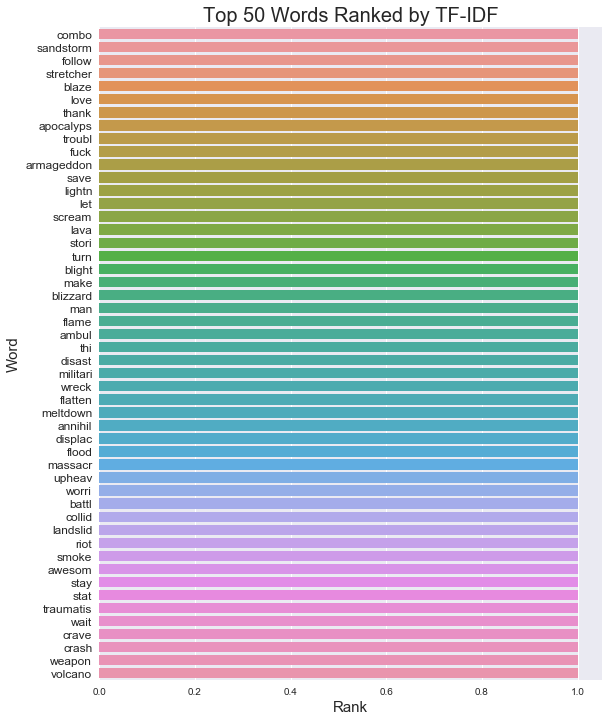

In [20]:
top_n = 50
top_features = X_tfidf_df.max().sort_values(ascending = False)[:top_n]

plt.figure(figsize = (9, 12))
plt.title(f'Top {top_n} Words Ranked by TF-IDF', fontsize = 20)
plt.ylabel('Word', fontsize = 15)
plt.xlabel('Rank', fontsize = 15)
plt.yticks(fontsize = 12)
sns.barplot(top_features.values, top_features.index)
plt.show()

### Save Vectorized Data